In [1]:
import os
import sys
from argparse import Namespace
from pathlib import Path

import pytorch_lightning as pl
import torch
from torchvision import transforms
from torchvision.datasets import MNIST, EMNIST
from tqdm import trange

In [2]:
# Update path to import src code
sys.path.append(".." + os.sep + "..")

In [3]:
from src import SplitNN, ConvAttackModel, plot_images, AttackDataset

In [4]:
project_root = Path.cwd().resolve().parents[1]

---
# 1. Data volume
In this experiment,
we will investigate model inversion attack efficacy on a target model
trained to classify MNIST images.
We will assess the impact of number of training data (for the attacker) on attack success
---

## Load target model
Load a model trained without noise

In [5]:
model_path = project_root / "models" / "splitnn_00noise_00nopeek.ckpt"

In [6]:
target_model = SplitNN.load_from_checkpoint(model_path)
target_model.prepare_data()

---
## Evaluate model

## Confirm target model performance

In [9]:
target_trainer = pl.Trainer(gpus=None, overfit_pct=0.5)  # use half of validation data
target_trainer.test(target_model, target_model.val_dataloader())

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.


--------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_loss': tensor(1.4809),
 'test_acc': tensor(98.2031),
 'test_loss': tensor(1.4809)}
--------------------------------------------------------------------------------



---
## Train attacker
We will train the attack model on EMNIST images.
These are similar enough to MNIST for the attack to work in principle,
but different enough to simulate a real-world attack setting (unknown training data).

## Create attacker datasets

In [10]:
emnist_train = EMNIST(project_root / "data", "letters", download=True, train=True, transform=data_transform)
emnist_train.data = emnist_train.data[: 2_000]
emnist_train.targets = emnist_train.targets[: 2_000]

emnist_val = EMNIST(project_root / "data", "letters", download=True, train=False, transform=data_transform)
emnist_val.data = emnist_val.data[: 2_000]
emnist_val.targets = emnist_val.targets[: 2_000]

emnist_trainloader = torch.utils.data.DataLoader(emnist_train, batch_size=128)
emnist_valloader = torch.utils.data.DataLoader(emnist_val, batch_size=128)

### noisy model dataset

In [12]:
attack_train = AttackDataset()
attack_val = AttackDataset()

# Train data
for data, _ in emnist_trainloader:
        data = data

        # Get target model output
        with torch.no_grad():
            _, intermediate_data = target_model(data)

        attack_train.push(intermediate_data, data)

# Validation data
for data, _ in emnist_valloader:
        data = data

        # Get target model output
        with torch.no_grad():
            _, intermediate_data = target_model(data)

        attack_val.push(intermediate_data, data)

attack_trainloader = torch.utils.data.DataLoader(attack_train, batch_size=128)
attack_valloader = torch.utils.data.DataLoader(attack_val, batch_size=128)

## Train attack models

In [13]:
attacker_hparams = Namespace(learning_rate=1e-4, max_epochs=10, batch_size=16)

In [14]:
attack_model = ConvAttackModel(attacker_hparams)

attack_trainer = pl.Trainer(max_epochs=attacker_hparams.max_epochs)
attack_trainer.fit(attack_model, attack_trainloader, attack_valloader)
attack_trainer.test(attack_model, test_dataloaders=attack_valloader)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.

  | Name     | Type            | Params
-----------------------------------------
0 | linear1  | Linear          | 4 M   
1 | layers   | Sequential      | 57 K  
2 | layers.0 | ConvTranspose2d | 36 K  
3 | layers.1 | ConvTranspose2d | 18 K  
4 | layers.2 | ConvTranspose2d | 2 K   
5 | layers.3 | ConvTranspose2d | 73    


--------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_loss': tensor(0.3322), 'test_loss': tensor(0.3322)}
--------------------------------------------------------------------------------



---
## Visualise reconstruction

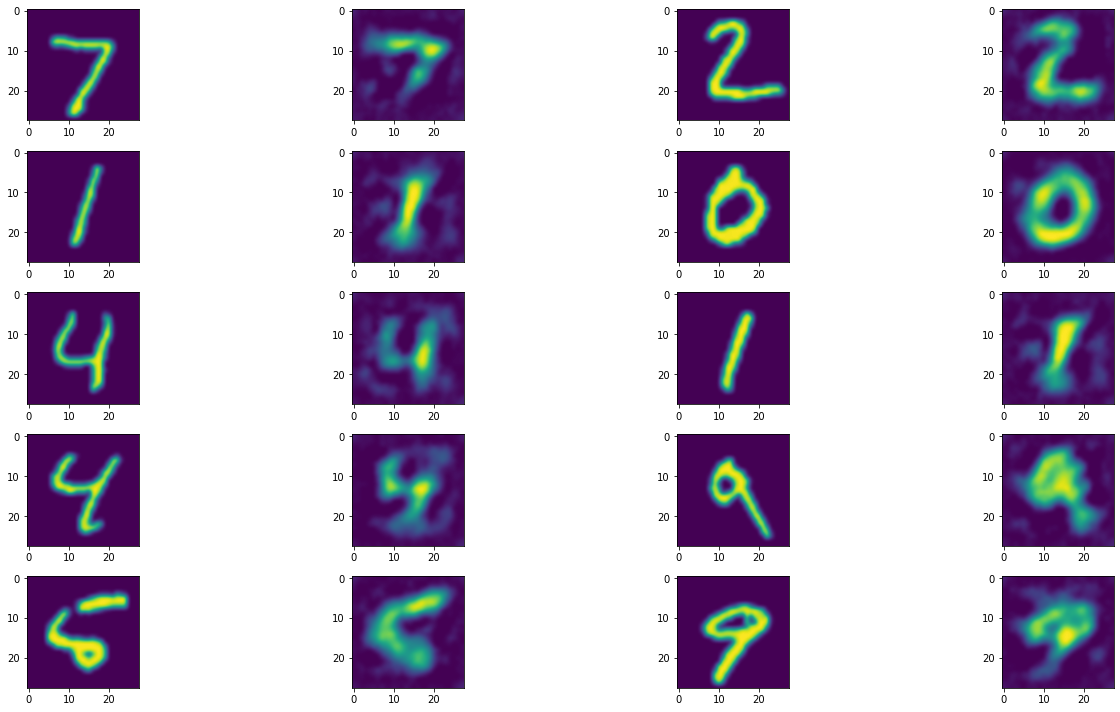

In [15]:
ims = []

for i in range(10):
    image, _ = target_model.val_data[i]

    with torch.no_grad():
        intermediate = target_model.encode(image.unsqueeze(0))
        reconstructed = attack_model(intermediate)

    reconstructed = reconstructed.squeeze(0)
    ims.extend([image, reconstructed])

plot_images(ims)